In [111]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras import Model, Sequential

In [112]:
import pandas as pd
import requests
import io

url = "https://alpha-vantage.p.rapidapi.com/query"

querystring = {"function":"TIME_SERIES_DAILY","symbol":"tsla","outputsize":"full","datatype":"csv"}

headers = {
    "X-RapidAPI-Key": "62a5337beamsh4b06b153b683dcep1db8cfjsn6419e7690224",
    "X-RapidAPI-Host": "alpha-vantage.p.rapidapi.com"
}

response = requests.request("GET", url, headers=headers, params=querystring)

In [113]:
# convert csv response to dataframe
df = pd.read_csv(io.StringIO(response.text))
# Reverse rows using iloc() Function
df = df.iloc[::-1]

df['timestamp'] = pd.to_datetime(df['timestamp'])

print(df.head())

      timestamp   open     high    low  close    volume
3220 2010-06-29  19.00  25.0000  17.54  23.89  18766300
3219 2010-06-30  25.79  30.4192  23.30  23.83  17187100
3218 2010-07-01  25.00  25.9200  20.27  21.96   8218800
3217 2010-07-02  23.00  23.1000  18.71  19.20   5139800
3216 2010-07-06  20.00  20.0000  15.83  16.11   6866900


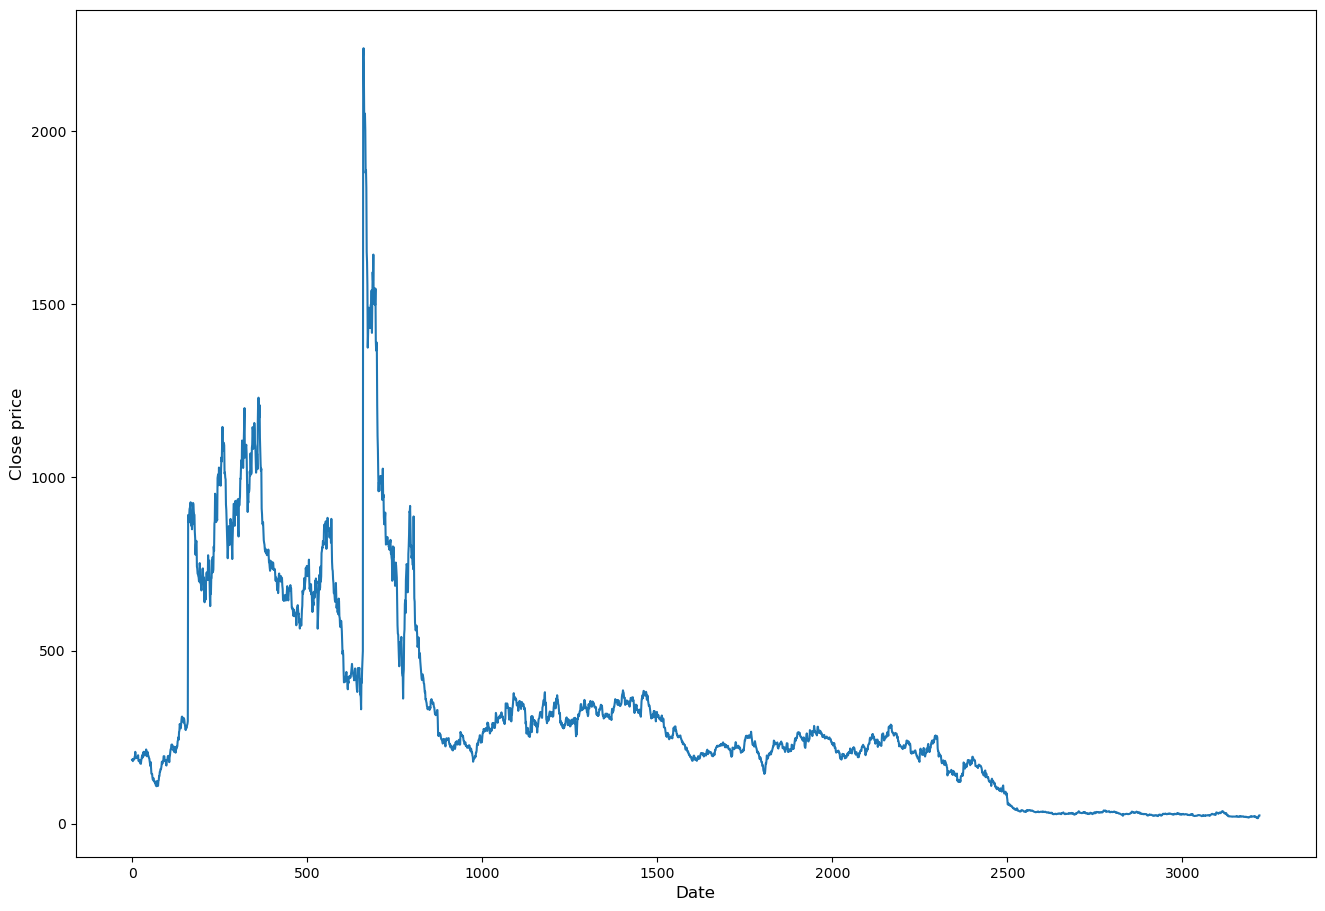

In [114]:
plt.figure(figsize=(16,11))
plt.plot(df['close'])
plt.xlabel('Date',fontsize = 12)
plt.ylabel('Close price',fontsize = 12)
plt.show()

In [115]:
data = df.filter(['close'])
dataset = data.values

In [116]:
scalar = MinMaxScaler(feature_range=(0,1))
scaled_data=scalar.fit_transform(dataset)
len(scaled_data)

3221

In [117]:
df['close'] = scaled_data

In [118]:
df.head()

,timestamp,open,high,low,close,volume
3220,2010-06-29,19.00,25.0000,17.54,0.003639,18766300
3219,2010-06-30,25.79,30.4192,23.30,0.003612,17187100
3218,2010-07-01,25.00,25.9200,20.27,0.002771,8218800
3217,2010-07-02,23.00,23.1000,18.71,0.001529,5139800
3216,2010-07-06,20.00,20.0000,15.83,0.000139,6866900


In [119]:
df = df.drop(['timestamp'], axis=1)
df.head()

,open,high,low,close,volume
3220,19.00,25.0000,17.54,0.003639,18766300
3219,25.79,30.4192,23.30,0.003612,17187100
3218,25.00,25.9200,20.27,0.002771,8218800
3217,23.00,23.1000,18.71,0.001529,5139800
3216,20.00,20.0000,15.83,0.000139,6866900


In [120]:
n = len(df)

# Split 70:20:10 (train:validation:test)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

train_df.shape, val_df.shape, test_df.shape

((2254, 5), (644, 5), (323, 5))

In [121]:
train_df.head()

,open,high,low,close,volume
3220,19.00,25.0000,17.54,0.003639,18766300
3219,25.79,30.4192,23.30,0.003612,17187100
3218,25.00,25.9200,20.27,0.002771,8218800
3217,23.00,23.1000,18.71,0.001529,5139800
3216,20.00,20.0000,15.83,0.000139,6866900


In [122]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels
    
    def plot(self, model=None, plot_col='close', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [123]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [124]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}
column_indices

{'open': 0, 'high': 1, 'low': 2, 'close': 3, 'volume': 4}

In [125]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['close'])

In [126]:
cnn_multi_window.input_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

In [127]:
cnn_multi_window.make_dataset(train_df)

<_MapDataset element_spec=(TensorSpec(shape=(None, 26, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float64, name=None))>

In [128]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    LSTM(32),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
69/69 [==============================] - 4s 26ms/step - loss: 0.0030 - mean_absolute_error: 0.0463 - val_loss: 0.0778 - val_mean_absolute_error: 0.2319
Epoch 2/50
69/69 [==============================] - 1s 16ms/step - loss: 0.0025 - mean_absolute_error: 0.0430 - val_loss: 0.0693 - val_mean_absolute_error: 0.2130
Epoch 3/50
69/69 [==============================] - 1s 15ms/step - loss: 0.0026 - mean_absolute_error: 0.0438 - val_loss: 0.0801 - val_mean_absolute_error: 0.2371
Epoch 4/50
69/69 [==============================] - 1s 15ms/step - loss: 0.0026 - mean_absolute_error: 0.0435 - val_loss: 0.0764 - val_mean_absolute_error: 0.2291
Epoch 5/50
69/69 [==============================] - 1s 15ms/step - loss: 0.0025 - mean_absolute_error: 0.0429 - val_loss: 0.0681 - val_mean_absolute_error: 0.2107
Epoch 6/50
69/69 [==============================] - 1s 15ms/step - loss: 0.0024 - mean_absolute_error: 0.0415 - val_loss: 0.0709 - val_mean_absolute_error: 0.2176
Epoch 7/50
69/69 [====

In [129]:
print(val_performance)

[0.07803919166326523, 0.23251616954803467]


In [130]:
print(performance)

[0.04203875735402107, 0.14570073783397675]
